In [407]:
# %load_ext autoreload
# %autoreload 2

In [408]:
import wordle

In [409]:
# we need unidecode to fix accents in certain words

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 7, 6
rcParams['figure.dpi'] = 60

import warnings
warnings.filterwarnings("ignore")


### Load words from dictionaries to be tested

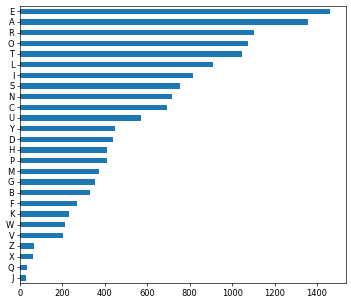

In [410]:
words_by_dictionary, df_by_dictionary = wordle.load_dictionaries()

### Main simulation function that gets parallelized

In [411]:

def run_query(qi, query, df_bkp, plot=False, log=False):
    # avoid printing warnings during parallel running
    import warnings; warnings.filterwarnings("ignore")
    
    day_i, dictionary_name, challenge_word, strategy = query
    
    if log:
        print(day_i, dictionary_name, challenge_word, strategy)
    select_by, sort_ascending = strategy
    guess_i = 0
    remaining_words = list(df_bkp['word'])
    
    assert challenge_word in remaining_words
    n_letters = len(remaining_words[0])
    
    last_guesses = set()
    
    while guess_i < 7:
        guess_i += 1    

        best_guess = wordle.infer(remaining_words, strategy[0], last_guesses=last_guesses)
        
        last_guesses.add(best_guess)
        remaining_words_by_guess = wordle.get_guesses(remaining_words, challenge_word, [best_guess])
        assert challenge_word in remaining_words

        if log:
            print('\n\nGUESS # %i' % guess_i, best_guess, len(remaining_words))
        
        
        remaining_words = remaining_words_by_guess[best_guess]
        
        
            ## the word has been guessed. Stop.
        if len(remaining_words) <= 1:
            # print('after this word, only %i words left' % len(remaining_words))
            # print('')
            if best_guess != remaining_words[0]:
                # print('last guess wrong. One additional guess wouldve been required')
                guess_i += 1
            break
        if log:
            print('left', len(remaining_words))
        
        wordle.plot_words(remaining_words, plot=plot, challenge_word=challenge_word)

    final_scores = [day_i, select_by, sort_ascending, dictionary_name, challenge_word, guess_i]
    # print(final_scores)
    
    return_dict[qi] = final_scores
    
    if log:
        print('day %i done...\n\n' % day_i)
        print('total guesses', guess_i)

### Simulate a challenge
#### Prepare queries for main function

In [412]:
import random
random.seed(500)

# strategy name, sorting type
strategies = [['wordfreq', False],
              ['posfreq', False],
              ['posfreqcovar', False]]

n_days = None # 30 # None # 15 #
# n_days = None  # test everything


all_words = []
for k in words_by_dictionary:
    words = words_by_dictionary[k]    
    if n_days is not None:
        if n_days <= len(words):
            words = random.sample(words, n_days)
    all_words += [[k, w] for w in words]    

queries = [[day_i, q[0], q[1], st] for day_i, q in enumerate(all_words) for st in strategies]
print(n_days, len(words), len(queries))

next_args = [[qi, q, df_by_dictionary[q[1]]] for qi, q in enumerate(queries)]
len(next_args)
# next_args[10][:2]

None 2315 48648


48648

In [413]:
import multiprocessing
manager = multiprocessing.Manager()
return_dict = manager.dict()

### Debug one case, to examine intermediat viz

In [414]:
# for q in next_args:
#     if q[1][2] == 'TABOO':
#         print(q)
        
custom_args = [q for q in next_args if len(q[1][2]) == 5]
# custom_args = next_args



11586 wordle_5 WRIST ['wordfreq', False]


GUESS # 1 ALERT 2315
left 24


GUESS # 2 FROST 24
left 4


GUESS # 3 CRUST 4
left 2


GUESS # 4 WRIST 2
day 11586 done...


total guesses 4


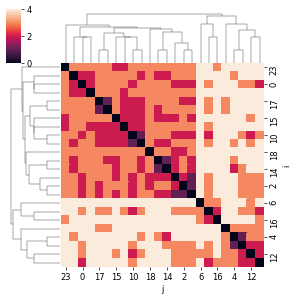

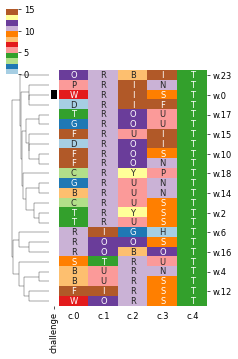

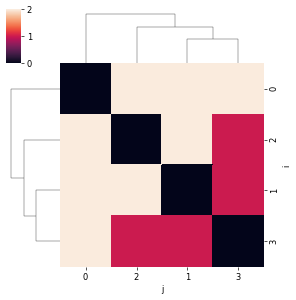

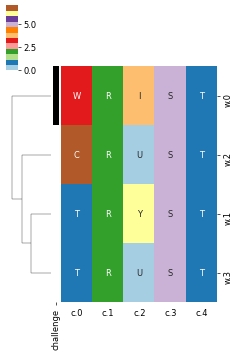

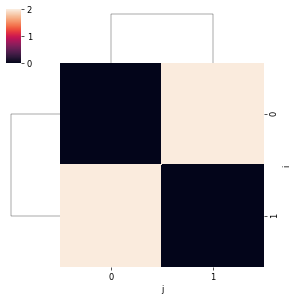

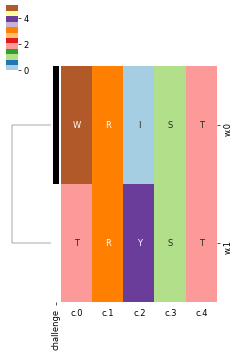

In [415]:
idx = 0
print('')
# print(next_args[idx])
print('')
run_query(custom_args[idx][0], custom_args[idx][1], custom_args[idx][2], plot=True, log=True)

#### Define the number of cores to be used (e.g. 2, based on device)

In [416]:
n_cores = 5

In [ ]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
wordle.ThreadingUtils.run(run_query, next_args, n_cores=n_cores, input_list_kwargs=[{} for args in next_args])

### Visualize results

In [ ]:
final_scores = []
for k in return_dict.keys():
    # print(k)
    # print(k, return_dict[k])
    next_scores = return_dict[k]
    
    final_scores.append(next_scores)
    if len(final_scores) == len(next_args):
        break

res = pd.DataFrame(final_scores, columns=['day.i', 'strategy', 'sort.ascending', 'dictionary.name', 'word', 'n.guesses'])
res['k'] = res['dictionary.name'] + ':' + res['word']
# matrix format
m = res.pivot('k', 'strategy', 'n.guesses')
res.sort_values('n.guesses', ascending=False).head()


In [430]:
res.shape

(48648, 7)

#### Visualizing number of guesses by strategy

In [431]:
# best covariation
m['diff'] = m['posfreqcovar'] - m['posfreq']
m.sort_values('diff', ascending=False).head()

strategy,posfreq,posfreqcovar,wordfreq,diff
k,,,,
wordle_4:PRES,2,8,7,6
american_4:PRES,2,8,7,6
american_4:SINE,2,7,7,5
american_3:EIR,2,7,7,5
wordle_4:STAR,2,7,8,5


In [432]:
# worst covariation
m.sort_values('diff', ascending=False).tail()

strategy,posfreq,posfreqcovar,wordfreq,diff
k,,,,
wordle_3:OEY,7,1,7,-6
american_5:BILLY,8,2,4,-6
wordle_3:MEO,8,2,7,-6
american_3:OEY,7,1,7,-6
wordle_5:BILLY,8,2,4,-6


In [433]:
res.groupby(['dictionary.name', 'strategy']).mean()[['n.guesses']] # .sort_values('n.guesses')

n.guesses
dictionary.name strategy               
american_3      posfreq        6.206537
                posfreqcovar   6.277803
                wordfreq       6.185656
american_4      posfreq        4.865738
                posfreqcovar   5.031476
                wordfreq       4.842897
american_5      posfreq        3.701944
                posfreqcovar   3.853564
                wordfreq       3.678186
wordle_3        posfreq        6.206537
                posfreqcovar   6.277803
                wordfreq       6.185656
wordle_4        posfreq        4.865738
                posfreqcovar   5.031476
                wordfreq       4.842897
wordle_5        posfreq        3.701944
                posfreqcovar   3.853564
                wordfreq       3.678186

In [434]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)


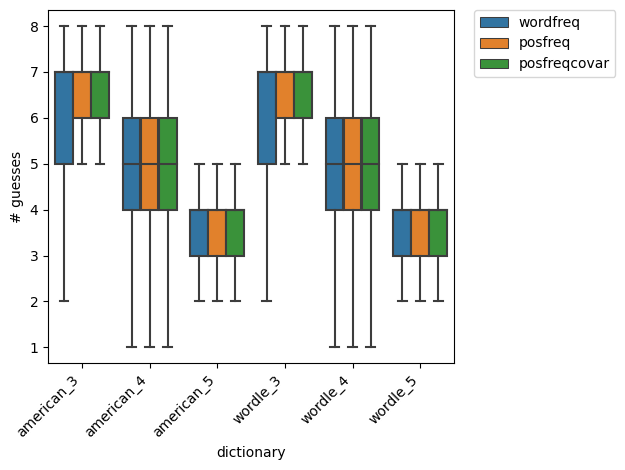

In [435]:
sns.boxplot(data=res, hue='strategy', y='n.guesses', x='dictionary.name', order=['american_3', 'american_4', 'american_5', 'wordle_3', 'wordle_4', 'wordle_5'],
            hue_order=['wordfreq', 'posfreq', 'posfreqcovar'], fliersize=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=45, ha='right')
plt.xlabel('dictionary')
plt.ylabel('# guesses')

plt.tight_layout()
plt.savefig('out/benchmarking_results.png')
plt.show()


In [436]:
res[res['dictionary.name'].str.endswith('_5')].groupby(['dictionary.name', 'strategy']).mean()[['n.guesses']] # .sort_values('n.guesses')

n.guesses
dictionary.name strategy               
american_5      posfreq        3.701944
                posfreqcovar   3.853564
                wordfreq       3.678186
wordle_5        posfreq        3.701944
                posfreqcovar   3.853564
                wordfreq       3.678186

In [437]:
for k, grp2 in grp[grp['dictionary.name'].str.endswith('_5')].groupby(['dictionary.name', 'strategy']):
    print(k, grp2.shape, np.mean(grp2['n.guesses']))

('american_5', 'wordfreq') (2315, 7) 3.678185745140389
('wordle_5', 'wordfreq') (2315, 7) 3.678185745140389


In [438]:
grp.shape

(4630, 7)

In [439]:
grp[['n.guesses']].mean()

n.guesses    3.678186
dtype: float64

No handles with labels found to put in legend.


                          n.guesses
dictionary.name strategy           
american_5      posfreq    3.701944
wordle_5        posfreq    3.701944
posfreq 4.0
posfreq 3.7019438444924404


No handles with labels found to put in legend.
No handles with labels found to put in legend.


                              n.guesses
dictionary.name strategy               
american_5      posfreqcovar   3.853564
wordle_5        posfreqcovar   3.853564
posfreqcovar 4.0
posfreqcovar 3.853563714902808
                          n.guesses
dictionary.name strategy           
american_5      wordfreq   3.678186
wordle_5        wordfreq   3.678186
wordfreq 4.0
wordfreq 3.678185745140389


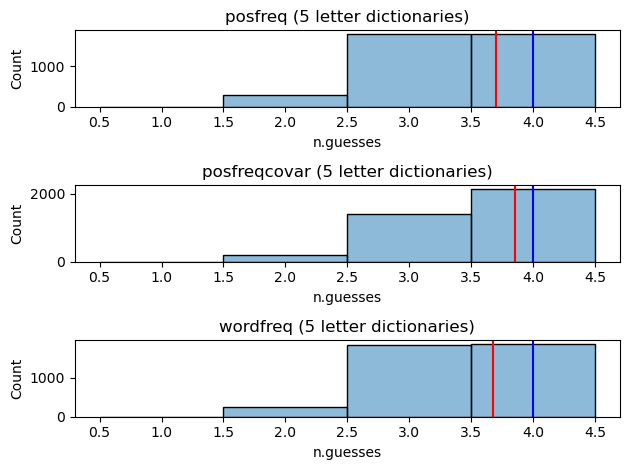

In [440]:
i = 1
for st, grp in res.groupby('strategy'):
    grp = grp[grp['dictionary.name'].str.endswith('_5')]
    ax = plt.subplot(3, 1, i)
    sns.histplot(grp, x='n.guesses', hue='strategy', ax=ax, bins=np.arange(0,5)+0.5) #  multiple='stack') # bins=4)
    i += 1
    plt.title(st + ' (5 letter dictionaries)')
    ax.legend().set_visible(False)
    
    print(grp[grp['dictionary.name'].str.endswith('_5')].groupby(['dictionary.name', 'strategy']).mean()[['n.guesses']]) # # .sort_values('n.guesses'))
    median = np.median(grp['n.guesses'].values)
    print(st, median)
    plt.axvline(median, c='blue')
    
    mean = np.mean(grp['n.guesses'].values)
    print(st, mean)
    plt.axvline(mean, c='red')

    ax.locator_params(axis='y', integer=True)

    
plt.tight_layout()

plt.savefig('out/benchmarking_5letters.png')
plt.show()


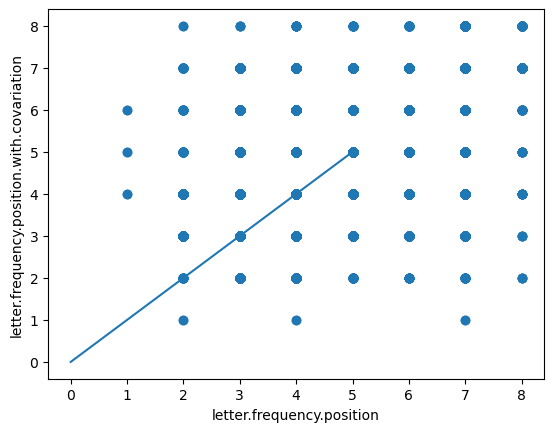

In [441]:
plt.scatter(m['posfreq'], m['posfreqcovar'])
plt.xlabel('letter.frequency.position')
plt.ylabel('letter.frequency.position.with.covariation')
plt.plot([0, 5], [0, 5])